In [35]:
# Import raw data from Excel
import pandas as pd
filepath = 'C:/Users/PXY/Desktop/Orange_week.xlsx';
sheetname = 'main'
df = pd.read_excel ( filepath, sheet_name = sheetname );
print (df)

     Year    Week  Cases  Rainfalls  No.of Raindays  Max. temperature  \
0    2010   week1    NaN        NaN             NaN               NaN   
1    2010   week2    NaN        NaN             NaN               NaN   
2    2010   week3    NaN        NaN             NaN               NaN   
3    2010   week4    NaN      286.0            22.0         32.883871   
4    2010   week5    NaN        NaN             NaN               NaN   
5    2010   week6    NaN        NaN             NaN               NaN   
6    2010   week7    NaN        NaN             NaN               NaN   
7    2010   week8   36.0      241.8            11.0         34.385714   
8    2010   week9   65.0        NaN             NaN               NaN   
9    2010  week10   46.0        NaN             NaN               NaN   
10   2010  week11   31.0        NaN             NaN               NaN   
11   2010  week12   27.0      191.8            14.0         34.338710   
12   2010  week13   40.0        NaN             NaN

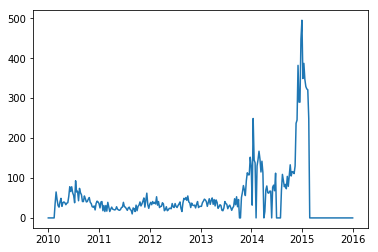

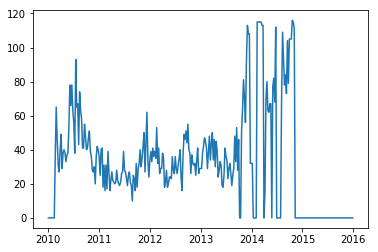

In [48]:
# Data preprocessing
# Set NaN to 0.0 for Cases & Fatality
df['Cases'].fillna( 0, inplace = True )
df['Fatality'].fillna(0, inplace = True )

# Set others to first found values
df['Rainfalls'].ffill( inplace = True );
df['Max. temperature'].ffill( inplace = True );
df['Min. temperature'].ffill( inplace = True );
df['Mean temp'].ffill( inplace = True );

# Ffill doesn't fill in the first three NaN, thus need to do another bfill
df['Rainfalls'].bfill( inplace = True );
df['Max. temperature'].bfill( inplace = True );
df['Min. temperature'].bfill( inplace = True );
df['Mean temp'].bfill( inplace = True );

# Add new column
import datetime 
date = []
for index,row in df.iterrows():
    row['Date'] = datetime.datetime.strptime( str( row['Year'])+ row['Week'] + "-1", "%Yweek%W-%w")
    date.append( row['Date'])

df['Date'] = date

# Verify if all the anomalies are gone and new column added succesfully
df.dtypes

# Create a new data frame
data = pd.DataFrame()
data['Date'] = df['Date']
data['Rainfalls'] = df['Rainfalls'];
data['Max. temperature'] = df['Max. temperature']
data['Min. temperature'] = df['Min. temperature']
data['Mean temp'] = df['Mean temp']
data['Cases'] = df['Cases']

# Show the data in chart
import matplotlib
import matplotlib.pyplot as plt
plt.figure()
dates = matplotlib.dates.date2num(df['Date'])
plt.plot_date(dates, df['Cases'], linestyle = 'solid', marker = 'None')


std_value = data['Cases'].std()
mean_value = data['Cases'].mean()
max_boundary = mean_value + std_value
min_boundary = max( mean_value - std_value, 0 )
index = ( data['Cases'] > max_boundary ) | ( data['Cases'] < min_boundary )

import numpy as np
data.loc[index,'Cases'] = np.nan
data['Cases'].bfill( inplace = True );
data['Cases'].ffill( inplace = True );

#print(df)
plt.figure()
plt.plot_date(dates, data['Cases'], linestyle = 'solid', marker = 'None' )

from scipy.signal import savgol_filter
filtered_case = savgol_filter(data['Cases'], 11,2)
#plt.plot_date(dates,filtered_case,color ='red', linestyle = 'solid', marker= 'None')
#plt.show()

In [38]:
# Normalizing data
# This step is really useful on improving model performance
import sklearn
from sklearn.preprocessing import MinMaxScaler
cols_to_norm = [ 'Rainfalls','Max. temperature','Min. temperature','Mean temp','Cases']
sc = MinMaxScaler();
scaled_data = data.copy()
scaled_data[cols_to_norm] = sc.fit_transform(data[cols_to_norm])
 
# Split into train and test sets",
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
train, test = scaled_data[:train_size], scaled_data.tail(test_size)

# Get the subset of the data for training
training_set = train.iloc[:, 1:6].values

# Create input for training
import numpy as np
X_train = []
y_train =[]
for i in range(60, len(training_set)):
    X_train.append(training_set[i-60:i,0]);
    y_train.append(training_set[i,4])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))   

In [39]:
# Build and train the model
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

regressor = tf.keras.Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
149/149 [==============================] - 11s 72ms/sample - loss: 0.0756
Epoch 2/100
149/149 [==============================] - 3s 18ms/sample - loss: 0.0316
Epoch 3/100
149/149 [==============================] - 3s 19ms/sample - loss: 0.0297
Epoch 4/100
149/149 [==============================] - 3s 20ms/sample - loss: 0.0266
Epoch 5/100
149/149 [==============================] - 3s 20ms/sample - loss: 0.0256
Epoch 6/100
149/149 [==============================] - 3s 23ms/sample - loss: 0.0246
Epoch 7/100
149/149 [==============================] - 3s 20ms/sample - loss: 0.0229
Epoch 8/100
149/149 [==============================] - 3s 21ms/sample - loss: 0.0214
Epoch 9/100
149/149 [===============

149/149 [==============================] - 3s 19ms/sample - loss: 0.0230
Epoch 82/100
149/149 [==============================] - 3s 18ms/sample - loss: 0.0199
Epoch 83/100
149/149 [==============================] - 3s 19ms/sample - loss: 0.0190
Epoch 84/100
149/149 [==============================] - 3s 20ms/sample - loss: 0.0198
Epoch 85/100
149/149 [==============================] - 3s 19ms/sample - loss: 0.0203
Epoch 86/100
149/149 [==============================] - 3s 18ms/sample - loss: 0.0193
Epoch 87/100
149/149 [==============================] - 3s 22ms/sample - loss: 0.0195
Epoch 88/100
149/149 [==============================] - 2s 16ms/sample - loss: 0.0193
Epoch 89/100
149/149 [==============================] - 3s 17ms/sample - loss: 0.0175
Epoch 90/100
149/149 [==============================] - 3s 17ms/sample - loss: 0.0170
Epoch 91/100
149/149 [==============================] - 3s 18ms/sample - loss: 0.0182
Epoch 92/100
149/149 [==============================] - 3s 19ms/sam

In [40]:
# Create test data
test_set = test.iloc[:, 1:4].values
inputs = test_set.reshape(-1,1)
real_cases = data['Cases'].tail(test_size).values

X_test = []
for i in range(60, len(test) + 60):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_cases = regressor.predict(X_test)

result = np.zeros(shape=(len(predicted_cases),5))
result[:,0] = predicted_cases[:,0]
predict = sc.inverse_transform(result)[:,0]

print(predict )

[112.78119431 113.83199618 115.57786293 117.16220714 118.63734431
 120.52797354 122.07833443 123.52045683 124.85161759 125.70447118
 126.07271506 126.17063643 125.77852983 125.0607673  124.24052141
 123.15819268 121.99788899 120.94547288 119.80678601 118.97049595
 118.14595477 117.56020923 117.42252133 117.32635458 117.39420892
 117.80466173 118.14188407 118.48769699 119.04922889 119.43271683
 119.73728935 119.92580484 119.94913415 120.1653725  120.64596767
 121.18147517 122.05899159 123.24322818 124.41584222 125.80840034
 127.34871082 128.69788091 130.10879929 131.44320257 132.90635223
 134.34451623 135.67093251 137.09334711 138.45905266 139.66892062
 140.87584082 141.96207182 142.84256406 143.63722069 144.28906597
 144.93863727 145.51663445 145.92251123 146.33894376 146.63572581
 146.73029236 146.92753879 147.0760772  147.10469843 147.36890085
 147.63537724 147.80011423 148.19115402 148.40969442 148.29947672
 148.44724311 148.26591451 147.66726906 147.32871322 146.59774197
 145.46443

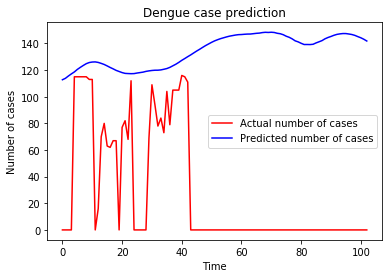

In [41]:
# Visualising the results
plt.plot(real_cases, color = 'red', label = 'Actual number of cases')
plt.plot(predict, color = 'blue', label = 'Predicted number of cases')
plt.title('Dengue case prediction')
plt.xlabel('Time')
plt.ylabel('Number of cases')
plt.legend()
plt.show()